# Simple synthetic data test

This is test of the gravity inversion code on synthetic data generated from a simple model. 

We'll use this example to show that the method works and is efficient. We'll also use it to compare the formulations using the Steepest Descent and Newton's method. The results show how each formulation performs on regularized problem using smoothness constraints.

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

## Using Gauss-Newton to impose smoothness


$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[ \mathbf{A}^T \mathbf{A} + \mu \mathbf{R}^T \mathbf{R} \right]^{-1} 
\left[ \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)] - \mu \mathbf{R}^T \mathbf{R}\mathbf{p}^k \right]
$$


Is there a difference between both methods? We've seen from the `moho-inversion-class.ipynb` notebook that the computation time is practically the same. If there is a difference, which is better?

## Package imports

Load the necessary libraries to run the inversion and make graphs.

In [1]:
# Insert the plots into the notebook
%matplotlib inline

Load the standard scientific Python stack to numerical analysis and plotting.

In [2]:
from __future__ import division
import multiprocessing
import cPickle as pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn  # Makes the default style of the plots nicer

The computations generate a lot of run-time warnings. They aren't anything to be concerned about so disable them to avoid clutter.

In [3]:
import warnings
warnings.simplefilter('ignore')

Load the required modules from [Fatiando a Terra](http://www.fatiando.org).

In [4]:
from fatiando.inversion import Smoothness2D
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import utils, gridder
import fatiando

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 3aed3f5676a45705b598bfc72f9883043097c854


Load our custom classes and functions.

In [6]:
from tesseroid_mesh import TesseroidRelief
from moho import MohoGravityInvSpherical, make_mesh

Get the number of cores in this computer to run the some things in parallel.

In [7]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 4


Some parameters about where and how to save the figures. Use this cell to make figures for the paper.

In [8]:
seaborn.plotting_context('paper')
fig_file = '../figures/paper/synth1-{}.eps'
fig_args = dict(facecolor='none')

Uncomment and run the cell below to make figures with larger text (for slides and posters).

In [161]:
#seaborn.plotting_context('poster')
#fig_file = '../figures/slides/synthetic-steepest-vs-newton/{}.png'
#fig_args = dict(dpi=300, facecolor='none')

## Create a model and generate synthetic data

Below we define a function that generates our tesseroid model of the Moho relief. The model assumes a homogeneous density contrast along the entire Moho. The relief of the Moho simulates the transition between continental and oceanic crust.

In [9]:
def generate_model():
    # Make a regular grid inside an area.
    # Grid points will be the center of the top of each tesseroid in the model
    shape = (40, 50)
    area = (10, 70, -50, 50)
    lat, lon = gridder.regular(area, shape)
    # Define our model Moho relief
    relief = (
        -25e3 + 15e3*sp.special.erf((lon - 10)/20) # The general flow from continent to ocean
        - 15e3*utils.gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
        + 15e3*utils.gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
        - 10e3*utils.gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
        - 10e3*utils.gaussian2d(lat, lon, 10, 10, x0=30, y0=25)**2
        + 5e3*utils.gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15))
    density_contrast = 600
    density = density_contrast*np.ones_like(relief)
    # Define the reference level (height in meters). 
    # This is the Moho depth of the Normal Earth
    reference = -30e3
    # The density contrast is negative if the relief is below the reference
    density[relief < reference] *= -1
    # Make a TesseroidRelief using the make_mesh utility function and 
    # assign the density contrast values to it.
    model = make_mesh(area, shape, relief, reference)
    model.addprop('density', density)
    # Print some information
    print(u"Density contrast: {} kg/m³".format(density_contrast))
    print(u"Reference level: {} m".format(reference))
    print(u"Number of tesseroids: {} x {} = {}".format(shape[0], shape[1], model.size))
    return model

In [10]:
model = generate_model()

Density contrast: 600 kg/m³
Reference level: -30000.0 m
Number of tesseroids: 40 x 50 = 2000


Lets make a plot of our Moho model.

In [11]:
bm = Basemap(projection='cyl', 
             llcrnrlon=model.area[2], urcrnrlon=model.area[3], 
             llcrnrlat=model.area[0], urcrnrlat=model.area[1],
             resolution='c')

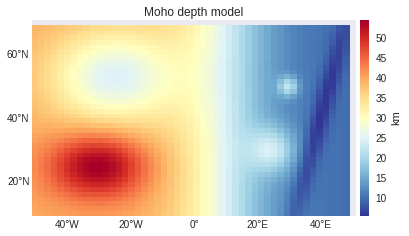

In [12]:
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))

plt.figure(figsize=(7, 3.5))
plt.title("Moho depth model")
bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='RdYlBu_r')
plt.colorbar(pad=0.01).set_label('km')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.savefig(fig_file.format('model'), **fig_args)

Generate the computation grid for our synthetic dataset. The grid will have half the spacing of the model. This way, we'll have more points than we'll need to run the inversion. The extra points will be separated into a *test dataset* for cross-validation (see section [Cross-validation](#Cross-validation) below).

In [13]:
# clon and clat are the coordinates of the center of each model cell
area = [model.clat.min(), model.clat.max(), model.clon.min(), model.clon.max()]
# Increase the shape to have half the grid spacing
full_shape = [s*2 - 1 for s in model.shape]
grid_height = 50e3
full_lat, full_lon, full_height = gridder.regular(area, full_shape, z=grid_height)
print('Number of grid points: {} x {} = {}'.format(full_shape[0], full_shape[1], full_shape[0]*full_shape[1]))
print('Grid height: {} m'.format(grid_height))

Number of grid points: 79 x 99 = 7821
Grid height: 50000.0 m


Forward model the synthetic data on a regular grid at a constant height and contaminate it with pseudo-random Gaussian noise.

In [14]:
full_data_noisefree = tesseroid.gz(full_lon, full_lat, full_height, model, njobs=ncpu)
full_data = utils.contaminate(full_data_noisefree, 5, seed=0)

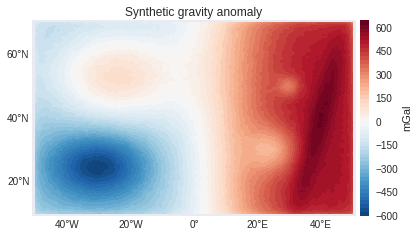

In [15]:
x, y = bm(full_lon, full_lat)

plt.figure(figsize=(7, 3.5))
plt.title('Synthetic gravity anomaly')
ranges = np.abs([full_data.max(), full_data.min()]).max()
bm.contourf(x, y, full_data, 50, cmap='RdBu_r', tri=True, vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01).set_label('mGal')
bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
plt.savefig(fig_file.format('data'), **fig_args)

## Cross-validation

We'll use cross-validation to determine the optimal value of the regularization parameter.
The way this works is:

1. Create a separate dataset that will be used to check our solutions (the test dataset $\mathbf{d}_{test}$)
2. Run the inversion on the observed data for each value of the regularization parameter
3. For each solution, calculate the predicted data for the **test dataset** ($\mathbf{d}'_{test}$ and the corresponding Mean Square Error (MSE) error.
4. Choose the solution with the smallest MSE value for the test dataset.

The MSE is

$$
MSE = \dfrac{[\mathbf{d}_{test} - \mathbf{d}'_{test}]^T[\mathbf{d}_{test} - \mathbf{d}'_{test}]}{N_{test}}
$$

First, we must separate the dataset into two parts: one for the inversion, another for cross-validation. The inversion dataset will have double the grid spacing and (for this test) must fall on top of each grid cell. The remaining data will be used for cross-validation.

In [16]:
def split_data(data, shape, every):
    data = [i.reshape(shape) for i in data]
    # Take every "every" points for the inversion
    inversion = [i[::every, ::every] for i in data]
    # mask marks the grid points I didn't take for inversion
    mask = np.ones(shape, dtype=np.bool)
    mask[::every, ::every] = False  # These are the ones I took
    test = [i[mask] for i in data]
    shape = inversion[0].shape
    # Sanity checks
    assert all(t.size + i.size == d.size for t, i, d in zip(test, inversion, data)), \
        "Number of points in inversion + test set different from original data."
    assert all(t.size == test[0].size for t in test), "Test set has differet number of points"
    assert all(i.size == inversion[0].size for i in inversion), "Inversion set has differet number of points"
    assert all(i.shape == inversion[0].shape for i in inversion), "Inversion set has differet shape"
    # Print some info
    print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], shape[0]*shape[1]))
    print("Number of test set points: {}".format(test[0].size))
    return [i.ravel() for i in inversion], test, shape

In [17]:
inversion_set, test_set, shape = split_data([full_lat, full_lon, full_height, full_data], full_shape, every=2)

Number of inversion grid points: 40 x 50 = 2000
Number of test set points: 5821


Test if the inversion set falls on top of the model cells.

In [18]:
lat, lon, height, data = inversion_set
assert np.allclose(model.clon.ravel(), lon, rtol=1e-10, atol=0)
assert np.allclose(model.clat.ravel(), lat, rtol=1e-10, atol=0)

No errors means that both checks (`assert`) passed.

We need a function that will calculate the score (MSE) a given solution against the test dataset.

In [19]:
def score_test_set(model, lat, lon, height, data, njobs=1):
    predicted = tesseroid.gz(lon, lat, height, model, njobs=njobs)
    score = np.sum((predicted - data)**2)/data.size
    return score

The score should be zero (perfect fit) if we pass in the error-free model data.

In [20]:
score_test_set(model, full_lat, full_lon, full_height, full_data_noisefree, njobs=ncpu)

0.0

Define some functions to perform the calculations for cross-validation in parallel (using multiple processes).

In [21]:
def fit_all(solvers, njobs=1): 
    """
    Run ``fit`` for all solvers using *njobs* processes.
    """
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(call_fit, solvers)
        pool.close()
        pool.join()
    else:
        results = map(call_fit, solvers)
    return results

def call_fit(solver):
    """
    Call the ``fit`` method of a solver object.
    If any exceptions arise, returns None.
    """
    try:
        solver.fit()
    except:
        solver = None
    return solver

In [22]:
def score_all(solutions, test_set, njobs=1):
    """
    Get the cross-validation score for all solutions using *njobs* processes.
    """
    args = [[s.estimate_, test_set] for s in solutions]
    if njobs > 1:
        pool = multiprocessing.Pool(njobs)
        results = pool.map(call_score, args)
        pool.close()
        pool.join()
    else:
        results = map(call_score, args)
    return results

def call_score(args):
    """
    Call score_test_set on the solution.
    
    Needed because multiprocessing.Pool.map only allows functions with
    a single argument.
    """
    solution, test_set = args
    try:
        score = score_test_set(solution, *test_set)
    except:
        score = np.nan
    return score

## Inversion setup

We need to make a mesh for the inversion. We'll use a mesh that is equal to the original model. This will make it easier to compare the inversion results with the true model.

In [23]:
mesh = model.copy(deep=True)

We also need to define an initial estimate because this is a non-linear inversion. Next, we create the data-misfit and regularization objects that we'll use in the inversions below.

In [24]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = np.ones(mesh.size)*(-60e3)

## Define plotting functions

These functions plot the results of the inversion for us. We'll define them all here and use them below for each inversion that we run.

In [51]:
def plot_fit(solver, bm):
    predicted = solver[0].predicted()
    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title('Observed and predicted data ({})'.format(solver.stats_['method']))    
    levels = mpl.contourf(lon, lat, data, shape, 25, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, predicted, shape, levels, basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    
def plot_residuals(solver):
    residuals = solver[0].residuals()
    
    plt.figure(figsize=(2.5, 2))
    plt.text(0.58, 0.8, 
             "mean = {:.2f}\n    std = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=15, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)

def plot_estimate(solver, bm):
    moho = solver.estimate_    
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 3.5))
    plt.title("Estimated Moho depth ({})".format(solver.stats_['method']))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='RdYlBu_r')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    
def plot_diff(solver, model, bm):
    moho = solver.estimate_    
    x, y = bm(moho.lons, moho.lats)
    
    diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
    ranges = np.abs([diff.max(), diff.min()]).max()
    
    plt.figure(figsize=(7, 3.5))
    plt.title('Difference between true and estimated ({})'.format(solver.stats_['method']))  
    bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-40, 45, 20), labels=[0, 0, 0, 1], linewidth=0)
    bm.drawparallels(np.arange(20, 65, 20), labels=[1, 0, 0, 0], linewidth=0)
    
def plot_cv(best, regul_params, scores, solver, log=True):    
    plt.figure(figsize=(5, 3.5))
    plt.title('Cross-validation for {}'.format(solver.stats_['method']))
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout()
    
def plot_convergence(solver):
    plt.figure(figsize=(5, 3.5))
    plt.title('Convergence of {}'.format(solver.stats_['method']))
    plt.plot(range(solver.stats_['iterations'] + 1), solver.stats_['objective'])
    plt.xlabel('Iteration')
    plt.yscale('log')
    plt.ylabel('Goal function')
    plt.tight_layout()

## Solution using Steepest Descent

Let's try using the steepest descent method first. We'll make a Python dictionary (`dict`) to store the solver configuration for this method. `tol` is the tolerance level that controls the stopping criterion. `maxit` is the maximum allowed number of iterations. `linesearch=False` tells the algorithm not to perform a line search for the step size. 

In [26]:
steep_config = dict(method='steepest', initial=initial, tol=0.1, maxit=10, linesearch=False)

Next, we define a list of the possible regularization parameters that will be considered during cross-validation. `logspace` generates a list of values evenly spaced in a logarithmic scale.

In [27]:
regul_params = np.logspace(-6, -1, 16)
regul_params

array([  1.00000000e-06,   2.15443469e-06,   4.64158883e-06,
         1.00000000e-05,   2.15443469e-05,   4.64158883e-05,
         1.00000000e-04,   2.15443469e-04,   4.64158883e-04,
         1.00000000e-03,   2.15443469e-03,   4.64158883e-03,
         1.00000000e-02,   2.15443469e-02,   4.64158883e-02,
         1.00000000e-01])

Run the inversion for each value in `regul_params` (in parallel using all available cores). 

In [27]:
%time results_steep = fit_all([(misfit + mu*regul).config(**steep_config) for mu in regul_params], njobs=ncpu)

CPU times: user 404 ms, sys: 120 ms, total: 524 ms
Wall time: 5min 19s


This takes some time to run. We can save the results to a [Python pickle file](https://docs.python.org/2/library/pickle.html) and load it later to avoid re-calculating every time.

In [28]:
with open('synthetic-steepest-vs-newton.steepest.pickle', 'w') as f:
    pickle.dump(results_steep, f)

Uncomment and use the cell below to load the saved results. This will save time when making and tweaking plots (so we don't need to do the long computation again).

In [28]:
#with open('synthetic-steepest-vs-newton.steepest.pickle') as f:
#    results_steep = pickle.load(f)

Score the results against the test dataset.

In [29]:
%time scores_steep = score_all(results_steep, test_set, njobs=ncpu)

CPU times: user 76 ms, sys: 36 ms, total: 112 ms
Wall time: 1min 39s


The best solution is the one with the smallest cross-validation score.

In [30]:
best = np.argmin(scores_steep)
solution_steep = results_steep[best]

Plot the cross-validation data. The graph will show the MSE per regularization parameter. The chosen solution is the one that minimizes the MSE.

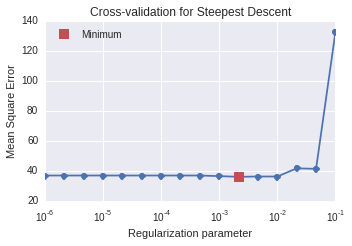

In [31]:
plot_cv(best, regul_params, scores_steep, solution_steep, log=False)
plt.savefig(fig_file.format('steep-cv'), **fig_args)

Plot the convergence of the best solution (goal function value per iteration) to see if the solution converges. Note that the y-axis is in a logarithmic scale.

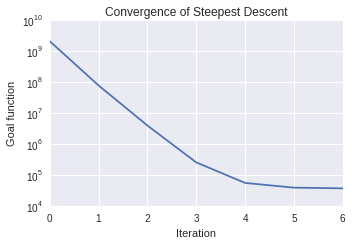

In [32]:
plot_convergence(solution_steep)
plt.savefig(fig_file.format('steep-convergence'), **fig_args)

Now we can plot the results for the best solution found using Steepest Descent. The maps below show the data fit (observed vs predicted), a histogram of the inversion residuals, the estimated Moho depth, and the difference between the estimated and true Moho depths.

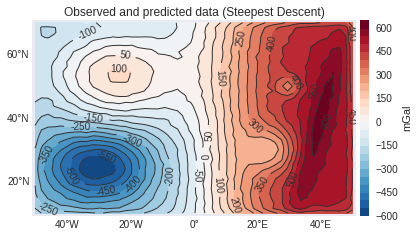

In [50]:
plot_fit(solution_steep, bm)
plt.savefig(fig_file.format('steep-fit'), **fig_args)

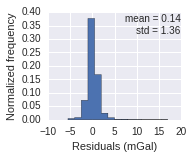

In [34]:
plot_residuals(solution_steep)
plt.savefig(fig_file.format('steep-residuals'), **fig_args)

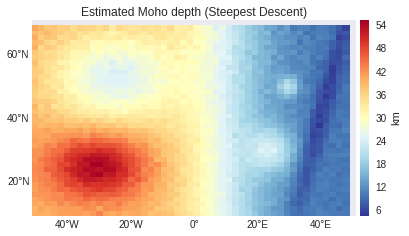

In [52]:
plot_estimate(solution_steep, bm)
plt.savefig(fig_file.format('steep-estimate'), **fig_args)

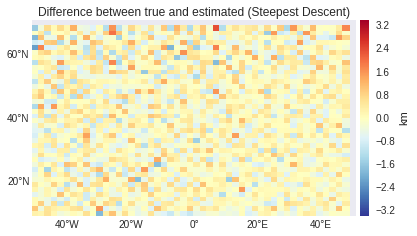

In [53]:
plot_diff(solution_steep, model, bm)
plt.savefig(fig_file.format('steep-diff'), **fig_args)

**Notice that the solution is still not smooth.** Even when using smoothness regularization, the solution using Steepest Descent does not provide a fully smooth Moho. The random errors in the data were still propagated to the solution.

The solution also seems to be over-fitting the data, even though we're using the optimal value determined by cross-validation. The predicted data fit even the high-frequency random noise in the data.

It seems that using only the gradient of the smoothness regularization with Steepest Descent is not enough to fully smooth the solution. However, this is the approach taken by [Santos et al. (2015)](http://dx.doi.org/10.1190%2Fgeo2014-0513.1) and they present smooth solutions. Maybe that is because they start out with a regularized solution as an initial estimate that is very close to the final solution already.

## Solution using Newton's method

Lets see if Newton's method yields a better solution. 

The configuration for the method is very similar to Steepest Descent but has no `linesearch` parameter.

In [37]:
newton_config = dict(method='newton', initial=initial, tol=0.1, maxit=15)

In [38]:
regul_params = np.logspace(-6, -1, 16)
regul_params

array([  1.00000000e-06,   2.15443469e-06,   4.64158883e-06,
         1.00000000e-05,   2.15443469e-05,   4.64158883e-05,
         1.00000000e-04,   2.15443469e-04,   4.64158883e-04,
         1.00000000e-03,   2.15443469e-03,   4.64158883e-03,
         1.00000000e-02,   2.15443469e-02,   4.64158883e-02,
         1.00000000e-01])

In [37]:
%time results_newton = fit_all([(misfit + mu*regul).config(**newton_config) for mu in regul_params], njobs=ncpu)

CPU times: user 648 ms, sys: 152 ms, total: 800 ms
Wall time: 6min 19s


Also save these results to a pickle file for later use.

In [38]:
with open('synthetic-steepest-vs-newton.newton.pickle', 'w') as f:
    pickle.dump(results_newton, f)

Uncomment and use the cell below to load the saved results. This will save time when making and tweaking plots (so we don't need to do the long computation again).

In [39]:
#with open('synthetic-steepest-vs-newton.newton.pickle') as f:
#    results_newton = pickle.load(f)

Score the results against the test dataset.

In [40]:
%time scores_newton = score_all(results_newton, test_set, njobs=ncpu)

CPU times: user 88 ms, sys: 28 ms, total: 116 ms
Wall time: 1min 40s


In [41]:
best = np.argmin(scores_newton)
solution_newton = results_newton[best]

Make the plots.

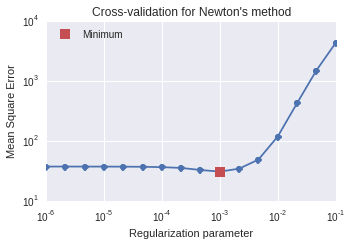

In [42]:
plot_cv(best, regul_params, scores_newton, solution_newton)
plt.savefig(fig_file.format('newton-cv'), **fig_args)

Notice that the cross-validation curve for Newton's method has a better defined minimum than for Steepest Descent.

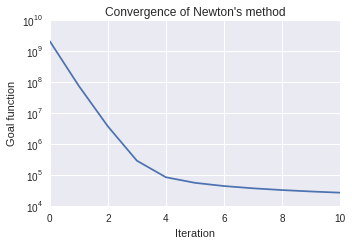

In [43]:
plot_convergence(solution_newton)
plt.savefig(fig_file.format('newton-convergence'), **fig_args)

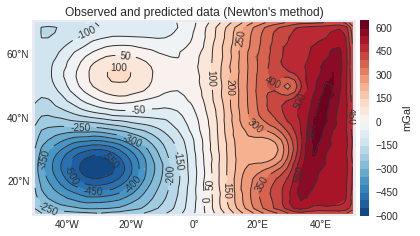

In [49]:
plot_fit(solution_newton, bm)
plt.savefig(fig_file.format('newton-fit'), **fig_args)

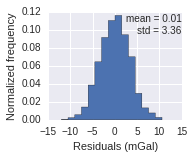

In [45]:
plot_residuals(solution_newton)
plt.savefig(fig_file.format('newton-residuals'), **fig_args)

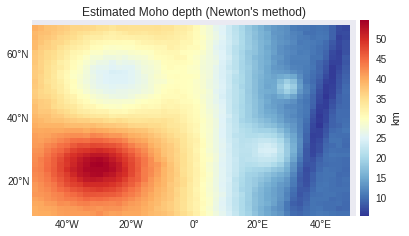

In [54]:
plot_estimate(solution_newton, bm)
plt.savefig(fig_file.format('newton-estimate'), **fig_args)

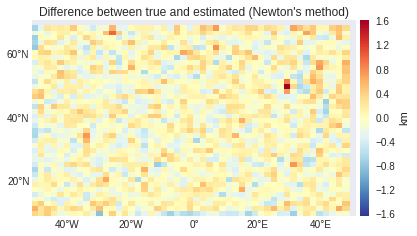

In [55]:
plot_diff(solution_newton, model, bm)
plt.savefig(fig_file.format('newton-diff'), **fig_args)

The solution using Newton's method is smoother than the solution for Steepest Descent. We can also see that this solution does not over-fit the data. The predicted data (black contour lines) don't present the random noise seen in the observed data. The standard deviation of the residuals is also closer to the 5 mGal standard deviation used to generate the data errors.